In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML
from datetime import datetime
from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
MODEL_NAME = "https://tfhub.dev/google/nnlm-en-dim50/2"

## GET DATA

In [9]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [10]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [11]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285192',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'},
 {'id': '223040',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/A7IOpPt-lHrMYsbRmxXWdQ__thumb/img/XoD3fXgApfY7-dfYyFeE6FVkbfY=/fit-in/200x150/filters:strip_icc()/pic6177962.jpg',
  'name': 'Fantasy Realms',
  'yearpublished': '2017'}]

In [12]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,285192,Alarka,N/A,Players: 1-3 (1-2) Time: 90-150 Min Category: ...
1,285192,almi,N/A,2021-05
2,285192,AnneWit,9.0,"On first play, this is another outstanding gam..."
3,285192,ArmyLee,N/A,KS Ed. - Sea of Sand - Myth & Folklore crossover
4,285192,Arvias,N/A,"Time of Legends: Destinies ""All in"" Core Box ..."
...,...,...,...,...
85859,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
85860,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
85861,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
85862,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [13]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [14]:
comments_df["value"] = comments_df["value"].astype(str)

In [15]:
# REMOVE URLs FROM COMMENTS

In [16]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [17]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [18]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14746 for 'remove_short_comments' - min len: 25 - method: unrated


In [19]:
# REMOVE NON ENGLISH COMMENTS

In [20]:
# !conda install -c conda-forge langdetect

In [21]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [22]:
# comments_df = add_comments_lang(comments_df)

In [23]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [24]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0       14462
9.0        13385
8.0        10813
N/A         6182
7.0         5963
           ...  
9.351          1
8.14           1
5.99           1
7.23333        1
8.5462         1
Name: rating, Length: 492, dtype: int64

In [25]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(64936, 5)

In [26]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6182, 5)

## CREATE TRAINING AND VALIDATION DATA

In [27]:
# use rated comments (reviews) to train the model

In [28]:
rated_comments = rated_comments.sample(frac=1)

In [29]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [30]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Excellent game!  Love the tense play half way through as your deck gets stronger and allows for more interesting play!  Winner and a keeper for the collection!!'

In [31]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Kickstarter'

In [32]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [33]:
def build_model(hub_layer, model_type='classifier', verbose=1):    
    if model_type not in ('classifier', 'regressor'):
        raise AttributeError("model type can only be 'classifier' or 'regressor'")

    if verbose:
        print("example of layers processing:")
        print(hub_layer(train_examples[:2]))
        print("")

    if model_type == 'classifier':
        model = tf.keras.Sequential()
        model.add(hub_layer)
        model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        if verbose:
            print("model summary:")
            print(model.summary())
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
        )
    else:
        model = tf.keras.Sequential()
        model.add(hub_layer)
        model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))
        
        if verbose:
            print("model summary:")
            print(model.summary())
            
        model.compile(
            loss='mean_squared_error', 
            optimizer='adam',
            metrics=["mean_squared_error"]
        )
    
    return model

In [34]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

In [35]:
model = build_model(hub_layer)

example of layers processing:
tf.Tensor(
[[ 0.4592822   0.27043217  0.13003437  0.26143998 -0.17791837 -0.01085548
   0.03381931 -0.15984881 -0.32419172  0.06540681  0.24596617  0.02785054
   0.23227185 -0.02990306  0.07645643 -0.14700769 -0.16748784 -0.03410842
   0.10029805 -0.26960805 -0.06652653 -0.15856323  0.17957798  0.15347748
   0.05984959  0.07482684 -0.33670896  0.23595154  0.08875988 -0.13586085
   0.10694648 -0.23072433  0.04164805 -0.30238754 -0.14900242 -0.07143868
   0.27885768  0.04768034  0.11574326 -0.4993029   0.20134637 -0.0186512
  -0.14360058  0.1443158   0.30534908 -0.12166248  0.01528035 -0.04508939
  -0.16277564  0.12654682]
 [-0.03433626 -0.0701631   0.10966539 -0.04545237  0.01302877  0.08797864
   0.06569442 -0.13900077 -0.26761138  0.05664901  0.1324492  -0.04833564
  -0.13775286  0.02205073  0.23299474  0.3055752  -0.15810198  0.2026449
   0.09309982  0.19039303 -0.05591495 -0.11657893  0.06650904 -0.286893
   0.01097949  0.03605929 -0.07441664  0.0603571

## TRAINING MODEL 

In [36]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
96/96 - 7s - loss: 0.5397 - accuracy: 0.7772 - val_loss: 0.4382 - val_accuracy: 0.8434
Epoch 2/40
96/96 - 5s - loss: 0.3697 - accuracy: 0.8585 - val_loss: 0.3458 - val_accuracy: 0.8637
Epoch 3/40
96/96 - 5s - loss: 0.2942 - accuracy: 0.8844 - val_loss: 0.3177 - val_accuracy: 0.8738
Epoch 4/40
96/96 - 5s - loss: 0.2512 - accuracy: 0.9014 - val_loss: 0.3142 - val_accuracy: 0.8775
Epoch 5/40
96/96 - 5s - loss: 0.2206 - accuracy: 0.9140 - val_loss: 0.3214 - val_accuracy: 0.8754
Epoch 6/40
96/96 - 5s - loss: 0.1968 - accuracy: 0.9246 - val_loss: 0.3406 - val_accuracy: 0.8725
Epoch 7/40
96/96 - 5s - loss: 0.1775 - accuracy: 0.9336 - val_loss: 0.3477 - val_accuracy: 0.8660
Epoch 8/40
96/96 - 5s - loss: 0.1609 - accuracy: 0.9410 - val_loss: 0.3688 - val_accuracy: 0.8646
Epoch 9/40
96/96 - 5s - loss: 0.1471 - accuracy: 0.9467 - val_loss: 0.3901 - val_accuracy: 0.8628


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [39]:
epochs = range(1, len(acc) + 1) 

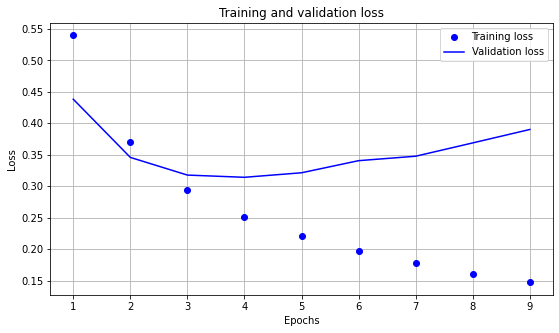

In [40]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

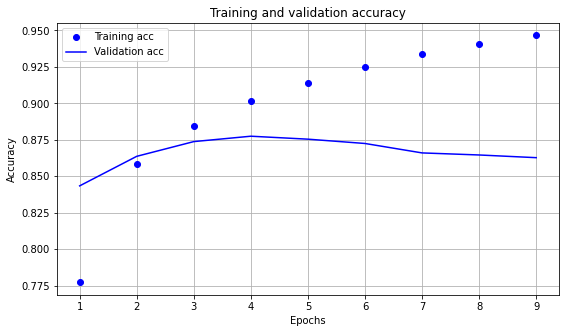

In [41]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [43]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"+Folded Space Inlay  Geschenk an und bei meinem Vater"
score: 0.998173
actual value:1

input:
"This is, by far, one of the best games I've ever played! It pulls in a lot of mechanics I really enjoy from games I play, and does them well; Hand Management, RPG (character growth), fighting, fantasy, etc. "
score: 0.998729
actual value:1

input:
"Terrific production in this fairly slow-paced euro with a dose of direct conflict.  The faction asymmetry is fun and the dopamine fix of constant upgrades is very enjoyable.  "
score: 0.811065
actual value:1

input:
"Very interesting mechanics so far.  Just hope the scenarios don't get samey."
score: 0.882905
actual value:1

input:
"The definitive edition of this glorious game. TI3 + Expansions addressed the Mercatol Rex End Game moshpit problem, but still had a bit of jank left over - a few too many burrs and bits of old growth. They sanded it all back down to the core, and applied layers of polish and fine tuning. It is now a game that in

In [44]:
## APPLY MODEL ON NON-RATED COMMENTS

In [45]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Limited Artists Edition with book and realistic tokens"
score: 0.991232

input:
"Expansions: Solo Campaign Book, Forgotten Circles  Upgrades: Plano Organization, Removable Stickers"
score: 0.950775

input:
"It's a great game. The major drawback is the amount of pieces and the setup/teardown time. I'm also not a huge fan of games that make you permanently alter the components because it reduces replayability. But, I think there is enough content here to last my group several years."
score: 0.991197

input:
"I'm going to need a someone else to get me into this one.  How is it great?  In 2017, this game was everywhere and could not escape it.  I un-boxed and set up but that's about as far as it went.  I will rate it...eventually.  "
score: 0.367804

input:
"Intimidating, I haven't even taken it out of the box. However, I do feel excited about it."
score: 0.511019

input:
"sadly missing the 'transmutation' tile on opening"
score: 0.770180

input:
"[b][COLOR=#0066FF]*** KICKSTARTER 

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [46]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.35 |        3509.00 |
| 167355.00 |          8.41 |        1792.00 |
| 167791.00 |          8.21 |        8221.00 |
| 169427.00 |          8.59 |         220.00 |
| 169786.00 |          8.10 |        7335.00 |


In [47]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [48]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 162886.00 |          8.78 |         309.00 |
| 167355.00 |          9.26 |         216.00 |
| 167791.00 |          8.96 |         438.00 |
| 169427.00 |          9.20 |          71.00 |
| 169786.00 |          8.66 |         589.00 |


In [49]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [50]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.186364,9.176667,8.495833,1,2021
1,"<img src=""https://cf.geekdo-images.com/A7IOpPt...","<a href=""https://boardgamegeek.com/boardgame/2...",7.383016,8.573333,7.471698,2,2017
2,"<img src=""https://cf.geekdo-images.com/OcnPGq9...","<a href=""https://boardgamegeek.com/boardgame/3...",7.865000,8.727273,8.050980,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.897605,8.853521,7.983625,4,2020
4,"<img src=""https://cf.geekdo-images.com/cwUgf-f...","<a href=""https://boardgamegeek.com/boardgame/2...",6.389669,8.917757,7.576096,5,2021


In [51]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [52]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Destinies,8.186364,9.176667,8.495833,1,2021
2,,Fantasy Realms,7.383016,8.573333,7.471698,2,2017
3,,The Adventures of Robin Hood,7.865000,8.727273,8.050980,3,2021
4,,Lost Ruins of Arnak,7.897605,8.853521,7.983625,4,2020
5,,Frosthaven,6.389669,8.917757,7.576096,5,2021


In [53]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.490566,9.755556,9.529032,38,2021
2,,The Witcher: Old World,9.208333,8.742857,9.036842,32,2022
3,,Eclipse: Second Dawn for the Galaxy,8.746143,8.948780,8.778036,47,2020
4,,Brass: Birmingham,8.688057,9.024454,8.718749,29,2018
5,,Gloomhaven: Jaws of the Lion,8.604304,8.584211,8.602302,20,2020


In [54]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.490566,9.755556,9.529032,38,2021
2,,The Witcher: Old World,9.208333,8.742857,9.036842,32,2022
3,,Mosaic: A Story of Civilization,7.000000,9.242857,8.962500,11,2022
4,,Kemet: Blood and Sand,8.454545,9.162963,8.894253,28,2021
5,,Eclipse: Second Dawn for the Galaxy,8.746143,8.948780,8.778036,47,2020


In [55]:
# model.save('saved_model\my_model')

In [56]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [57]:
# some examples on "long" comments vs short comments

In [58]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results)

input:
"It's 'fine'. But I don't understand why this game is rated so highly. Pretty to look at? Sure. Is that enough? Nope."
score: 0.097623

input:
"I look at this game as an efficiency engine. Could have been a lot better if the combat system is more than just secretly turning dials. Anticlimactic end game trigger also didn't help. Components are very nice though."
score: 0.233510

input:
"For as much as I was excited for this game, I could never actually get it on the table. I've head the game supposedly gets better and better with each play, but as getting game 1 in was a struggle itself I decided to trade it for something I knew would see more play!"
score: 0.320959

input:
"I have played Gloomhaven a nunmber of times with a friend (his copy), and think that this smaller version may be fun for me and my husband to play."
score: 0.415120

input:
"- Marvel Champions: The Card Game – Star Lord Hero Pack - Marvel Champions: The Card Game – Gamora Hero Pack - Marvel Champions: The Car

## REGRESSOR

In [59]:
# create training X and y
x_train_reg = list(rated_comments.value)
y_train_reg = list(rated_comments.rating.astype(int))

def build_regressor():
    return build_model(hub_layer, model_type='regressor', verbose=0)
estimator = KerasRegressor(build_fn=build_regressor, epochs=10, batch_size=512, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, x_train_reg, y_train_reg, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -4.35 (1.18) MSE


In [60]:
regressor = build_regressor()

In [61]:
regressor.fit(
    x_train_reg,
    y_train_reg,
    epochs=10,
    batch_size=512,
    # validation_data=(x_val, y_val),
    verbose=2,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
#     ]
)

Epoch 1/10
127/127 - 6s - loss: 37.6818 - mean_squared_error: 37.6818
Epoch 2/10
127/127 - 6s - loss: 9.9212 - mean_squared_error: 9.9212
Epoch 3/10
127/127 - 6s - loss: 7.3574 - mean_squared_error: 7.3574
Epoch 4/10
127/127 - 6s - loss: 5.9950 - mean_squared_error: 5.9950
Epoch 5/10
127/127 - 6s - loss: 4.7521 - mean_squared_error: 4.7521
Epoch 6/10
127/127 - 6s - loss: 3.8641 - mean_squared_error: 3.8641
Epoch 7/10
127/127 - 6s - loss: 3.0879 - mean_squared_error: 3.0879
Epoch 8/10
127/127 - 6s - loss: 2.4300 - mean_squared_error: 2.4300
Epoch 9/10
127/127 - 6s - loss: 1.9776 - mean_squared_error: 1.9776
Epoch 10/10
127/127 - 6s - loss: 1.7073 - mean_squared_error: 1.7073


In [62]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = regressor.predict(tf.constant(inputs))
print_my_examples(inputs, results, outputs)

input:
"Excellent game!  Love the tense play half way through as your deck gets stronger and allows for more interesting play!  Winner and a keeper for the collection!!"
score: 8.639480
actual value:9

input:
"Kickstarter"
score: 8.327463
actual value:6

input:
"This is a really good reimplemantation of Terra Mystica. It is different enough to stand by itself. I am a sucker for space games, and Terra Mystica is one of my favourite games ever so the combination really appeals to me.   But I still give this a lower rating than Terra Mystica since it is not as balanced. A few strategies are much stronger than others, and thus the different races become unbalanced due to how they fit to those strategies. "
score: 8.682869
actual value:9

input:
"Played twice and lost both times due to weak opening hands. It becomes quite obvious that your opponent is going to win when they have a stronger hand and you just go through the motions to end the game. Dragons also seem weak,  not worth their cos